In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import time
import datetime
import geocoder
pd.set_option('display.max_rows',500)
pd.set_option('display.max_columns',50)
pd.set_option('max_colwidth',200)
%matplotlib inline
import requests
import json
import urllib
from urllib.request import urlopen

def getGeoForAddress(address):
    add = urllib.parse.quote(address)
    addressUrl = "https://maps.googleapis.com/maps/api/geocode/json?address=" + add + '&key='
    res = requests.get(addressUrl)
    js = json.loads(res.text)
    if js.get('results'):
        lat = js.get('results')[0]['geometry']['location']['lat']
        lng = js.get('results')[0]['geometry']['location']['lng']
    else:
        lat = ''
        lng = ''
    return [lat, lng]
def ngram(text, n=3, pad=True):
    text = text.strip()
    if pad:
        text = " %s " % text
    return set([text[i:i+n] for i in range(len(text)-n+1)])
    
def create_ngram(text1, text2, n=3, pad=True):
    return ngram(text1, n=n, pad=pad), ngram(text2, n=n, pad=pad)

def tversky_index(text1, text2, a=None, b=None, q=3, pad=True):
    text1, text2 = create_ngram(text1, text2, n=q, pad=pad)
    agree_tot = len(text1.intersection(text2))
    v1 = len(text1) - agree_tot
    v2 = len(text2) - agree_tot
    
    if a != None and b != None:
        a = a/float(a+b)
        b = b/float(a+b)
    elif a <= 1.0 and a >= 0.0:
        b = 1-a
    elif b <= 1.0 and b >= 0.0:
        a = 1-b
    else:
        a = 0.5
        b = 0.5        
    return float(agree_tot)/(agree_tot+a*v1+b*v2)
# incoPat為申請人list
def fuzzy(incoPat,indus):
    corptype = ['有限','公司','责任','集团','股份','控股']
    text1 = incoPat
    text2 = indus
    incoPat_nor = []   
    for text in text1:
        for i in corptype:
            if i in text:
                text = re.sub(i,'',text)
        incoPat_nor.append(text)
    for i in corptype:
        if i in text2:
            text2 = re.sub(i,'',text2)
    similar = []
    for text in incoPat_nor:
        dice = tversky_index(text,text2, a=0.5, q=min(2,len(text),len(text2)), pad=False)
        if dice>0.7:
            similar.append([incoPat[incoPat_nor.index(text)],dice])
        else:
            pass
    if len(similar)>0:
        return similar[[k[1] for k in similar].index(max([i[1] for i in similar]))][0]
    else:
        return indus
city_code = pd.read_excel('C:/Users/user/Dropbox/paper/科技園區/China/省地縣碼對照.xls')
city_code = city_code[~city_code['代碼'].isnull()].drop(['标注','说明'],axis=1)
city_code['代碼_str'] = city_code['代碼'].apply(lambda x:str(int(x)))
city_code = city_code.drop('代碼',axis=1)

# 天津資料整合

In [2]:
df1 = pd.read_excel(r'E:\paper\專利資料-新型&授權\新型授權-天津1.xls')
df2 = pd.read_excel(r'E:\paper\專利資料-新型&授權\新型授權-天津2.xls')
df3 = pd.read_excel(r'E:\paper\專利資料-新型&授權\新型授權-天津3.xls')
patent_df = pd.concat([df1,df2,df3],ignore_index=True,sort=True)

In [7]:
patent_df.shape

(147799, 38)

In [8]:
patent_df['申请人地址'].fillna('',inplace=True)
patent_df = patent_df[patent_df['申请人地址']!='']

In [9]:
patent_df.shape

(147799, 38)

In [3]:
#for PC
patent_df = patent_df[patent_df['专利类型']=='发明授权']
patent_df = patent_df[patent_df['申请人地址'].map(lambda x:len(re.findall(r'\D+[\s\S]+',x)))==1]
patent_df['申请人地址'] = patent_df['申请人地址'].map(lambda x:re.findall(r'\D+[\s\S]+',x)[0])
patent_df['申请人地址'] = patent_df['申请人地址'].map(lambda x:re.sub(r"\s+", "",x))
patent_df_firm = patent_df[patent_df['申请人类型'].str.contains('企业')]
applicant = patent_df_firm['申请人'].str.split(';',expand=True).stack().reset_index(level=1,drop=True).rename('申请人2')
patent_df_firm = patent_df_firm.join(applicant)
patent_df_firm['類別'] = patent_df_firm['申请人类型'].map(lambda x:x.strip().split('  '))
patent_df_firm = patent_df_firm[~patent_df_firm['标题'].duplicated()]
patent_df_firm['申请人类型'] = patent_df_firm.apply(lambda x:x['類別'][0],axis=1)
patent_df_firm = patent_df_firm[patent_df_firm['申请人类型']=='企业'].sort_values('申请日')
patent_df_firm.drop(['類別','申请人'],axis=1,inplace=True)
patent_df_firm.rename(columns={'申请人2':'申请人'},inplace=True)
patent_df_firm = patent_df_firm[patent_df_firm['申请日']<datetime.datetime.strptime('2013-01-01','%Y-%m-%d')]
patent_df_firm.drop_duplicates('申请人地址', keep='last', inplace=True)
patent_df_firm.drop_duplicates('申请人', keep='last', inplace=True)

firm_df = pd.read_csv(r'E:\paper\Firm csv\firm_data_2012.csv')
firm_gd = firm_df[firm_df['區域代碼'].astype(str).str.contains(r'12\d{10}')==True]
firm_gd = firm_gd.loc[:,['法人代碼','企業名稱','地址','區域代碼','行業代碼']]
firm_gd['區域代碼_str'] = firm_gd['區域代碼'].astype(str).map(lambda x:x[0:6])
firm_gd = pd.merge(firm_gd,city_code,left_on='區域代碼_str',right_on='代碼_str',how='left')
firm_gd['名稱'].fillna('',inplace=True)
firm_gd['市級'].fillna('',inplace=True)
firm_gd['省份'].fillna('',inplace=True)
firm_gd['地址'].fillna('',inplace=True)
firm_gd['地址'] = firm_gd['地址'].map(lambda x:re.sub(r"\s+", "",x))
firm_gd['地址'] = firm_gd.apply(lambda x:re.sub(x['省份'],"",x['地址']),axis=1)
firm_gd['地址'] = firm_gd.apply(lambda x:re.sub(x['市級'],"",x['地址']),axis=1)
firm_gd['地址'] = firm_gd.apply(lambda x:re.sub(x['名稱'],"",x['地址']),axis=1)
firm_gd['地址'] = firm_gd['省份']+firm_gd['市級']+firm_gd['名稱']+firm_gd['地址']
firm_gd.drop(['省份','市級','名稱','代碼_str'],axis=1,inplace=True)
firm_gd.dropna(subset=['企業名稱'],inplace=True)

D:\Anaconda\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (0,3,16) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [12]:
patent_df_firm = patent_df_firm[patent_df_firm['申请日']>datetime.datetime.strptime('2007-12-31','%Y-%m-%d')]
incoPat = list(patent_df_firm['申请人'])

In [18]:
patent_df_firm.shape

(9080, 38)

In [16]:
firm_gd.shape

(4840, 6)

In [19]:
firm_gd['name_模糊比對'] = firm_gd['企業名稱'].map(lambda x:fuzzy(incoPat,x))

In [20]:
firm_gd.to_excel(r'E:\paper\清理結果-新型&授權\天津_廠商.xlsx')

# 非模糊比對

In [21]:
merge_df = firm_gd.merge(patent_df_firm,left_on='企業名稱',right_on='申请人',how='outer')
merge_df.fillna('',inplace=True)
print(merge_df[(merge_df['企業名稱']!='')&(merge_df['申请人']!='')].shape)
print(merge_df.shape)

(1405, 45)
(12515, 45)


In [22]:
merge_df['name'] = merge_df.apply(lambda x:x['申请人'] if x['申请人']!='' else x['企業名稱'],axis=1)
merge_df['address'] = merge_df.apply(lambda x:x['申请人地址'] if x['申请人地址']!='' else x['地址'],axis=1)
merge_df_clean = merge_df[merge_df['address'].str.contains(r'\w+(街|道|路|巷|村|小区|园区|社区)')]
merge_df_clean['address'] = merge_df_clean['address'].map(lambda x: x+'号' if ((x[-1].isdigit()) and (re.match(r'\w+[街道路巷]',x))) else x)
merge_df_clean['完整地址'] = merge_df_clean['address'].map(lambda x:1 if re.compile(r'\w+[街道路巷]\S+号').search(x) else 0)
merge_df_clean.loc[:,'lat'] = 0
merge_df_clean.loc[:,'lnt'] = 0
print(merge_df_clean[merge_df_clean['完整地址']==1].shape)
print(merge_df_clean.shape)

(6386, 50)
(10153, 50)


D:\Anaconda\lib\site-packages\pandas\core\strings.py:1843: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)
D:\Anaconda\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
D:\Anaconda\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
D:\Anaconda\lib\site-packages\pandas\core\indexing.py:376: SettingWithCopyWarning: 
A

In [23]:
merge_df_clean.to_excel(r'E:\paper\清理結果-新型&授權\天津_結果.xlsx')

# merge舊資料

In [15]:
merge_df = firm_gd.merge(patent_df_firm,left_on='企業名稱',right_on='申请人',how='outer')
merge_df.fillna('',inplace=True)
print(merge_df[(merge_df['企業名稱']!='')&(merge_df['申请人']!='')].shape)
print(merge_df.shape)
merge_df['name'] = merge_df.apply(lambda x:x['申请人'] if x['申请人']!='' else x['企業名稱'],axis=1)
merge_df['address'] = merge_df.apply(lambda x:x['申请人地址'] if x['申请人地址']!='' else x['地址'],axis=1)
merge_df = merge_df[merge_df['address']!='']
merge_df_clean = merge_df
merge_df_clean['address'] = merge_df_clean['address'].map(lambda x: x+'号' if ((x[-1].isdigit()) and (re.match(r'\w+[街道路巷]',x))) else x)
merge_df_clean['完整地址'] = merge_df_clean['address'].map(lambda x:1 if re.compile(r'\w+[街道路巷]\S+号').search(x) else 0)
merge_df_clean.loc[:,'lat'] = 0
merge_df_clean.loc[:,'lnt'] = 0
print(merge_df_clean[merge_df_clean['完整地址']==1].shape)
print(merge_df_clean.shape)

(492, 44)
(6533, 44)
(2950, 49)
(6501, 49)


In [16]:
done_data = pd.read_excel(r'E:\paper\清理結果-園區內外\天津_結果.xlsx')
done_data.columns

Index(['Unnamed: 0', '法人代碼', '企業名稱', '地址', '區域代碼', '行業代碼', '區域代碼_str',
       'name_模糊比對', 'CPC', 'IPC', 'inpadoc同族', 'inpadoc同族个数', '专利寿命（月）',
       '专利类型', '中国申请人区县', '中国申请人地市', '优先权信息', '公开国别', '公开（公告）号', '公开（公告）日',
       '发明人', '合享价值度', '同族国家', '失效日', '序号', '引证专利', '引证科技文献', '扩展同族', '扩展同族个数',
       '文献页数', '权利要求数量', '标准化申请人', '标题', '申请人', '申请人国别代码', '申请人地址', '申请人省市代码',
       '申请人类型', '申请号', '申请日', '简单同族', '简单同族个数', '被引证专利', '被引证国别(forward)',
       '被引证次数', '链接到incoPat', 'name', 'address', '完整地址', 'lat', 'lnt', '天津濱海',
       '專利數', '早期園區', '近期園區'],
      dtype='object')

In [17]:
merge_df_clean.drop(['lat','lnt'],axis=1,inplace=True)
merge_df_clean = merge_df_clean.merge(done_data[['name','lat','lnt','天津濱海','專利數','早期園區','近期園區']],left_on='name',right_on='name',how='left')
merge_df_clean['lat'].fillna('',inplace=True)
merge_df_clean[merge_df_clean['lat']==''].shape

(1987, 53)

In [18]:
merge_df_clean.to_excel(r'E:\paper\清理結果-新\天津_結果.xlsx')

# 模糊比對

In [24]:
merge_df_fuzzy = firm_gd.merge(patent_df_firm,left_on='name_模糊比對',right_on='申请人',how='outer')
merge_df_fuzzy.fillna('',inplace=True)
merge_df_fuzzy.drop_duplicates(['name_模糊比對','申请人'], keep='last', inplace=True)
print(merge_df_fuzzy[(merge_df_fuzzy['申请人']!='')&(merge_df_fuzzy['企業名稱']!='')].shape)
print(merge_df_fuzzy.shape)

(1574, 45)
(12278, 45)


In [25]:
merge_df_fuzzy['name'] = merge_df_fuzzy.apply(lambda x:x['申请人'] if x['申请人']!='' else x['企業名稱'],axis=1)
merge_df_fuzzy['address'] = merge_df_fuzzy.apply(lambda x:x['申请人地址'] if x['申请人地址']!='' else x['地址'],axis=1)
merge_df_fuzzy_clean = merge_df_fuzzy[merge_df_fuzzy['address'].str.contains(r'\w+(街|道|路|巷|村|小区|园区|社区)')]
merge_df_fuzzy_clean['address'] = merge_df_fuzzy_clean['address'].map(lambda x: x+'号' if ((x[-1].isdigit()) and (re.match(r'\w+[街道路巷]',x))) else x)
merge_df_fuzzy_clean['完整地址'] = merge_df_fuzzy_clean['address'].map(lambda x:1 if re.compile(r'\w+[街道路巷]\S+号').search(x) else 0)
merge_df_fuzzy_clean.loc[:,'lat'] = 0
merge_df_fuzzy_clean.loc[:,'lnt'] = 0
print(merge_df_fuzzy_clean[merge_df_fuzzy_clean['完整地址']==1].shape)
print(merge_df_fuzzy_clean.shape)

(6321, 50)
(10014, 50)


D:\Anaconda\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
D:\Anaconda\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [26]:
merge_df_fuzzy_clean.to_excel(r'E:\paper\清理結果-新型&授權\天津_模糊結果.xlsx')

# 定位

In [2]:
merge_df_clean = pd.read_excel(r'E:\paper\清理結果-新型&授權\天津_結果.xlsx',index_col=0)

In [3]:
merge_df_clean = pd.read_excel(r'E:\paper\清理結果-新\天津_結果.xlsx',index_col=0)
merge_df_clean.fillna('',inplace=True)
merge_df_clean[merge_df_clean['lat']==''].shape

(1987, 53)

In [4]:
for i in merge_df_clean[merge_df_clean['lat']==''].index:
    address = merge_df_clean.loc[i,'address']
    g = getGeoForAddress(address)
    merge_df_clean.loc[i,'lat'] = g[0]
    merge_df_clean.loc[i,'lnt'] = g[1]

In [5]:
print(merge_df_clean.shape)
print(merge_df_clean[merge_df_clean['lat']==''].shape)

(6501, 53)
(177, 53)


In [6]:
merge_df_clean.to_excel(r'E:\paper\清理結果-新\天津_結果.xlsx')

# 作圖

In [7]:
from geopy.distance import geodesic
def how_far(a,b):
    try:
        return geodesic(a,b).kilometers
    except:
        return np.nan
applicant = patent_df['申请人'].str.split(';',expand=True).stack().reset_index(level=1,drop=True).rename('申请人2')
applicant = applicant.map(lambda x:x.strip())
patent_df_new = patent_df.join(applicant)
patent_count = patent_df_new.groupby('申请人2')['标题'].count().rename('專利數')

In [8]:
patent_count.sort_values()

申请人2
BETAFENCE金属制品(天津)有限公司       1
曹国平                         1
曹嘉坤                         1
曹启武                         1
曹双成                         1
                         ... 
天津工业大学                   1357
河北工业大学                   1684
南开大学                     1933
乐金电子(天津)电器有限公司           3078
天津大学                     7053
Name: 專利數, Length: 34006, dtype: int64

In [5]:
merge_df = pd.read_excel(r'E:\paper\清理結果-新型&授權\天津_結果.xlsx',index_col=0)
target1 = (39.09561,117.12518)
merge_df['天津濱海'] = merge_df.apply(lambda x:how_far(target1,(x['lat'],x['lnt'])),axis=1)
merge_df = merge_df.merge(patent_count,left_on='name',right_on='申请人2',how='left')
merge_df['專利數'].fillna(0,inplace=True)

In [9]:
merge_df = pd.read_excel(r'E:\paper\清理結果-新\天津_結果.xlsx',index_col=0)
merge_df.fillna('',inplace=True)
merge_df.drop('專利數',axis=1,inplace=True)
target1 = (39.09561,117.12518)

for i in merge_df[merge_df['天津濱海']==''].index:
    merge_df.loc[i,'天津濱海'] = how_far(target1,(merge_df.loc[i,'lat'],merge_df.loc[i,'lnt']))
merge_df = merge_df.merge(patent_count,left_on='name',right_on='申请人2',how='left')
merge_df['專利數'].fillna(0,inplace=True)

In [10]:
merge_df['早期園區'] = merge_df.apply(lambda x:1 if (x['天津濱海']<10) else 0,axis=1)
merge_df['近期園區'] = 0

In [11]:
merge_df.to_excel(r'E:\paper\清理結果-新園區內外\天津_結果.xlsx')

In [12]:
print(merge_df.shape)
print(len(merge_df[merge_df['專利數']==0]['專利數'])/len(merge_df['專利數']))
print(len(merge_df[merge_df['專利數']>=100]['專利數'])/len(merge_df['專利數']))

(6501, 53)
0.48500230733733274
0.012767266574373173


In [13]:
merge_df.groupby('專利數')['IPC'].count()

專利數
0.0       3153
1.0        697
2.0        424
3.0        229
4.0        177
5.0        147
6.0        146
7.0        132
8.0        102
9.0         94
10.0        83
11.0        70
12.0        73
13.0        61
14.0        54
15.0        44
16.0        55
17.0        39
18.0        31
19.0        44
20.0        20
21.0        26
22.0        27
23.0        34
24.0        20
25.0        23
26.0        30
27.0        19
28.0        14
29.0        19
30.0        16
31.0        12
32.0         7
33.0        15
34.0         9
35.0        12
36.0        10
37.0         9
38.0         9
39.0         6
40.0         8
41.0        15
42.0         5
43.0         7
44.0         9
45.0         8
46.0         7
47.0         5
48.0         5
49.0         7
50.0         6
51.0        12
52.0         3
53.0         7
54.0        10
55.0         1
56.0         6
57.0         9
58.0         5
59.0         6
60.0         2
61.0         2
62.0         5
63.0         3
64.0         2
65.0         3
66.0  

In [14]:
merge_df[merge_df['lat']==''].groupby('專利數')['IPC'].count()

專利數
0.0     149
1.0       6
2.0       4
3.0       4
4.0       2
5.0       1
6.0       1
8.0       2
10.0      2
11.0      1
15.0      1
26.0      1
41.0      1
61.0      1
63.0      1
Name: IPC, dtype: int64

Text(0, 0.5, '無法定位廠商數量')

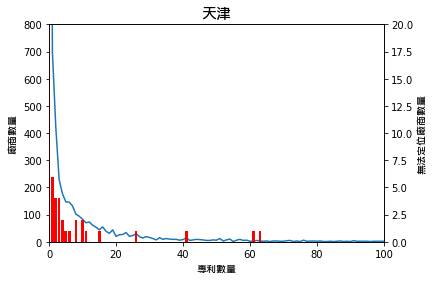

In [15]:
from matplotlib.font_manager import FontProperties
myfont = FontProperties(fname=r'C:\Windows\Fonts\msjhbd.ttc')
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.plot(merge_df[merge_df['lat']!=0].groupby('專利數')['IPC'].count().index,merge_df[merge_df['lat']!=0].groupby('專利數')['IPC'].count())
ax1.set_title('天津',fontproperties=myfont,fontsize=15)
ax1.set_ylabel('廠商數量',fontproperties=myfont)
ax1.set_xlabel('專利數量',fontproperties=myfont)
ax1.set_xlim([0,100])
ax1.set_ylim([0,800])
ax2 = ax1.twinx()
ax2.bar(merge_df[merge_df['lat']==''].groupby('專利數')['IPC'].count().index,merge_df[merge_df['lat']==''].groupby('專利數')['IPC'].count(),color='red')
ax2.set_ylim([0,20])
ax2.set_ylabel('無法定位廠商數量',fontproperties=myfont)


In [2]:
region = pd.read_excel(r'E:\paper\清理結果-新園區內外\天津_結果.xlsx',index_col=0)
region.fillna('',inplace=True)
corptype = ['有限','公司','责任','集团','股份','控股','总公司','分公司']
region['name_clean'] = region['name']
for k in corptype:
    region['name_clean'] = region['name_clean'].map(lambda x:re.sub(k,'',x))
region['name_clean'] = region['name_clean'].map(lambda x:re.sub(r'\(.*?\)','',x))
region['name_clean'] = region['name_clean'].map(lambda x:re.sub(r'\（.*?\）','',x))
region['name_clean'] = region['name_clean'].map(lambda x:re.sub(r'\(.*?\）','',x))
region['name_clean'] = region['name_clean'].map(lambda x:re.sub(r'\（.*?\)','',x))
region['name_clean'] = region['name_clean'].map(lambda x:re.sub(r'[\s+-─]','',x))
clean = region[region.duplicated(['name_clean'],keep=False)].sort_values(by=['企業名稱'])
patents = clean.groupby('name_clean')['專利數'].sum()
final = clean.drop('專利數',axis=1).merge(patents,left_on='name_clean',right_on='name_clean',how='left')
final.drop_duplicates(['name_clean'],keep='last',inplace=True)
region.drop_duplicates(['name_clean'],keep=False,inplace=True)
cleaned = pd.concat([region,final],ignore_index=True,sort=False)
located = cleaned[cleaned['lat']!='']
not_merge = located[located['企業名稱']=='']
print(len(not_merge['專利數']))
print(len(not_merge['專利數'])/len(located['專利數']))
print(len(not_merge[not_merge['專利數']>100]['專利數']))

1602
0.25644309268448856
25


In [3]:
not_merge.groupby('專利數')['IPC'].count()

專利數
1      403
2      245
3      135
4      100
5       70
6       60
7       57
8       42
9       42
10      30
11      27
12      30
13      23
14      22
15      13
16      23
17      13
18      11
19      19
20      10
21      11
22      11
23       9
24      11
25      11
26      14
27       6
28       6
29       8
30       6
31       5
32       1
33       6
34       5
35       4
36       5
37       4
38       3
39       3
41       7
42       1
43       2
44       6
45       4
46       3
47       3
49       3
50       3
51       4
52       1
53       1
54       3
55       1
56       1
57       3
58       1
59       2
60       1
62       4
65       2
67       1
68       1
70       1
72       2
74       1
76       2
77       1
79       1
83       1
84       1
85       1
89       1
97       1
98       1
100      1
101      1
102      1
105      1
107      1
110      1
112      1
116      1
122      1
124      1
132      1
141      1
148      1
153      1
209      2
217      1
221   

In [4]:
not_merge[not_merge['專利數']>=300].sort_values('專利數')

,法人代碼,企業名稱,地址,區域代碼,行業代碼,區域代碼_str,CPC,IPC,inpadoc同族,inpadoc同族个数,专利寿命（月）,专利类型,中国申请人区县,中国申请人地市,优先权信息,公开国别,公开（公告）号,公开（公告）日,发明人,合享价值度,同族国家,失效日,序号,引证专利,引证科技文献,...,标准化申请人,标题,申请人国别代码,申请人地址,申请人省市代码,申请人类型,申请号,申请日,简单同族,简单同族个数,被引证专利,被引证国别(forward),被引证次数,链接到incoPat,申请人,name,address,完整地址,lat,lnt,天津濱海,早期園區,近期園區,專利數,name_clean
6136,,,,,,,,E01B7/00; E01B7/18; E01B7/02; E01B7/12,CN102852055B; CN102852055A,2,,发明授权,[河北],[天津],,CN,CN102852055B,2015-05-13 00:00:00,刘道通; 程保青; 田苗盛; 杨宝峰; 杨其振; 于春华,9,CN,,16923,CN2730917Y; KR1020120075842A,"<text>张桂云.60kg/m钢轨9号单开道岔设计.《铁道标准设计》.1989, (第03期), </text>",...,,城市轨道交通用单开道岔,中国,天津市河北区中山路10号,天津; 12,企业,CN201210389648.3,2012-10-15 00:00:00,CN102852055B; CN102852055A,2,,,0,到incoPat中查看\r\nCN102852055B,铁道第三勘察设计院集团有限公司,铁道第三勘察设计院集团有限公司,天津市河北区中山路10号,1,39.1673,117.234,12.301212,0,0,314,铁道第三勘察设计院
6310,,,,,,,,C21D9/70; F27D1/16,CN105543467B; CN103898311B; CN103898311A; CN105543467A; CN105695725B,5,,发明授权,[滨海],[天津],,CN,CN105695725B,2018-08-03 00:00:00,高美忠; 张鹏飞,9,CN,,459,CN105543467A,,...,[中冶集团-C],配有膨胀缝的环形加热炉炉底工作层施工方法,中国,天津市滨海新区空港经济区西二道88号,天津; 12,企业,CN201610074622.8,2012-12-26 00:00:00,CN105695725A; CN105695725B,2,,,0,到incoPat中查看\r\nCN105695725B,中冶天工集团有限公司,中冶天工集团有限公司,天津市滨海新区空港经济区西二道88号,1,39.1538,117.392,23.967696,0,0,316,中冶天工
6312,,,,,,,,H01L35/34,CN103022338B; CN103022338A,2,0,发明授权,[西青],[天津],,CN,CN103022338B,2017-05-03 00:00:00,张丽丽; 任保国; 刘静榕,9,CN,,2269,CN1604353A; CN102308400A; CN101794766A; CN101040392A; JP10022532A; CN102187488A,,...,[中国电科-T],级联温差发电器件的制备方法,中国,天津市西青区海泰工业园华科七路6号,天津; 12,企业,CN201210576701.0,2012-12-26 00:00:00,CN103022338B; CN103022338A,2,,,0,到incoPat中查看\r\nCN103022338B,中国电子科技集团公司第十八研究所,中国电子科技集团公司第十八研究所,天津市西青区海泰工业园华科七路6号,1,39.0963,117.068,4.970065,1,0,388,中国电子科技第十八研究所
5128,,,,,,,,A61J3/06; F25D13/00; F25D15/00,CN101229099A; CN101229099B,2,,发明授权,[河东],[天津],,CN,CN101229099B,2011-06-08 00:00:00,闫希军; 孙小兵; 张文生; 荣昌盛; 王世庆; 章顺楠; 刘军,10,CN,,36724,CN201154086Y; CN1857391A; WO2007083562A1; CN2508752Y,,...,[天士力司-C],采用冷风加冷阱冷却气体制备滴丸的设备,中国,天津市北辰科技园区普济河东道2号天士力现代中药城,天津; 12,企业,CN200710060641.6,2007-12-28 00:00:00,CN101229099B; CN101229099A,2,,,0,到incoPat中查看\r\nCN101229099B,天津天士力制药股份有限公司,天津天士力制药股份有限公司,天津市北辰科技园区普济河东道2号天士力现代中药城,1,39.2096,117.215,14.859711,0,0,449,天津天士力制药
6047,,,,,,,,E02D29/16,CN102900103A; CN102900103B,2,0,发明授权,[东丽],[天津],,CN,CN102900103B,2014-11-26 00:00:00,肖策; 宋建信; 宋增力; 蒋伟; 王占东; 李剑; 谢飞; 邹树荣; 叶志翔; 陈大刚,9,CN,,30792,CN101403218A; CN202347544U; CN101503872A; KR100730517B1; JP2006249721A,,...,[中冶集团-C],一种地下防水混凝土结构的施工缝及其墙体模板安装方法,中国,天津市东丽区无瑕街天津二十冶,天津; 12,企业,CN201210299188.5,2012-08-21 00:00:00,CN102900103B; CN102900103A,2,,,0,到incoPat中查看\r\nCN102900103B,天津二十冶建设有限公司,天津二十冶建设有限公司,天津市东丽区无瑕街天津二十冶,0,39.0472,117.503,33.122302,0,0,462,天津二十冶建设
5997,,,,,,,,E02D33/00,CN102776902B; CN102776902A,2,0,发明授权,[滨海新],[天津],,CN,CN102776902B,2014-05-21 00:00:00,张立敏; 段前忠; 王存贵; 刘义猛; 郭亚军; 王冲; 刘聚杰,9,CN,,41474,,,...,[中国建筑-C],用于基坑围护结构变形测量的测斜管的绑扎方法,中国,天津市塘沽杭州道72号,天津; 12,企业,CN201210239273.2,2012-07-11 00:00:00,CN102776902B; CN102776902A,2,,,0,到incoPat中查看\r\nCN102776902B,中国建筑第六工程局有限公司,中国建筑第六工程局有限公司,天津市塘沽杭州道72号,1,39.0381,117.645,45.440548,0,0,563,中国建筑第六工程局


Text(0.5, 0, '專利數量')

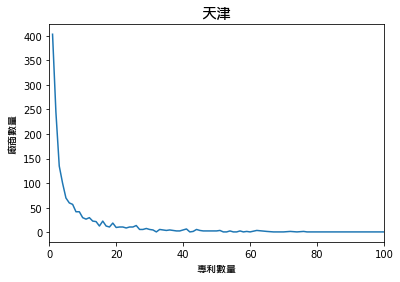

In [5]:
from matplotlib.font_manager import FontProperties
myfont = FontProperties(fname=r'C:\Windows\Fonts\msjhbd.ttc')
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.plot(not_merge.groupby('專利數')['IPC'].count().index,not_merge.groupby('專利數')['IPC'].count())
ax1.set_title('天津',fontproperties=myfont,fontsize=15)
ax1.set_xlim([0,100])
ax1.set_ylabel('廠商數量',fontproperties=myfont)
ax1.set_xlabel('專利數量',fontproperties=myfont)

In [6]:
cleaned.to_excel(r'E:\paper\名稱merge\天津_結果.xlsx')

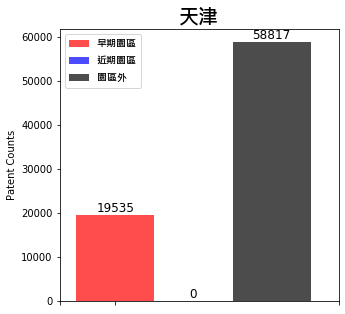

In [9]:
from matplotlib.font_manager import FontProperties
myfont = FontProperties(fname=r'C:\Windows\Fonts\msjhbd.ttc')
fig = plt.figure(figsize = (5,5))
ax1 = fig.add_subplot(111)
ax1.set_ylabel('Patent Counts')
bar1 = ax1.bar(1,merge_df[merge_df['早期園區']==1]['專利數'].sum(),alpha=0.7,width=0.35,color='r',label='早期園區')
bar2 = ax1.bar(1+0.35,merge_df[merge_df['近期園區']==1]['專利數'].sum(),alpha=0.7,width=0.35,color='b',label='近期園區')
bar3 = ax1.bar(1+0.7,merge_df[(merge_df['近期園區']==0)&(merge_df['早期園區']==0)]['專利數'].sum(),alpha=0.7,width=0.35,color='k',label='園區外')

plt.text(1, merge_df[merge_df['早期園區']==1]['專利數'].sum(), '%.0f' % merge_df[merge_df['早期園區']==1]['專利數'].sum(), ha='center', va= 'bottom',fontsize=12)  
plt.text(1.35, merge_df[merge_df['近期園區']==1]['專利數'].sum(), '%.0f' % merge_df[merge_df['近期園區']==1]['專利數'].sum(), ha='center', va= 'bottom',fontsize=12)  
plt.text(1.7, merge_df[(merge_df['近期園區']==0)&(merge_df['早期園區']==0)]['專利數'].sum(), '%.0f' % merge_df[(merge_df['近期園區']==0)&(merge_df['早期園區']==0)]['專利數'].sum(), ha='center', va= 'bottom',fontsize=12)  

plt.title('天津',fontproperties=myfont,fontsize=20)
plt.xticks([0.75,1,2],['','',''],fontproperties=myfont)
plt.legend(handles = [bar1,bar2,bar3], loc='upper left',prop=myfont)

D:\Anaconda\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in double_scalars
  """
D:\Anaconda\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in double_scalars
  if __name__ == '__main__':


posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


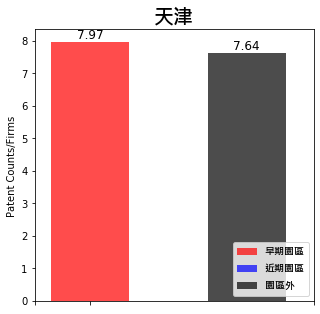

In [13]:
fig = plt.figure(figsize = (5,5))
ax1 = fig.add_subplot(111)
ax1.set_ylabel('Patent Counts/Firms ')
bar1 = ax1.bar(1,merge_df[merge_df['早期園區']==1]['專利數'].sum()/merge_df[merge_df['早期園區']==1]['專利數'].count(),alpha=0.7,width=0.35,color='r',label='早期園區')
bar2 = ax1.bar(1+0.35,merge_df[merge_df['近期園區']==1]['專利數'].sum()/merge_df[merge_df['近期園區']==1]['專利數'].count(),alpha=0.7,width=0.35,color='b',label='近期園區')
bar3 = ax1.bar(1+0.7,merge_df[(merge_df['近期園區']==0)&(merge_df['早期園區']==0)]['專利數'].sum()/merge_df[(merge_df['近期園區']==0)&(merge_df['早期園區']==0)]['專利數'].count(),alpha=0.7,width=0.35,color='k',label='園區外')

plt.text(1, (merge_df[merge_df['早期園區']==1]['專利數'].sum()/merge_df[merge_df['早期園區']==1]['專利數'].count()), '%.2f' % (merge_df[merge_df['早期園區']==1]['專利數'].sum()/merge_df[merge_df['早期園區']==1]['專利數'].count()), ha='center', va= 'bottom',fontsize=12)  
plt.text(1.35, (merge_df[merge_df['近期園區']==1]['專利數'].sum()/merge_df[merge_df['近期園區']==1]['專利數'].count()), '%.2f' % (merge_df[merge_df['近期園區']==1]['專利數'].sum()/merge_df[merge_df['近期園區']==1]['專利數'].count()), ha='center', va= 'bottom',fontsize=12)  
plt.text(1.7, (merge_df[(merge_df['近期園區']==0)&(merge_df['早期園區']==0)]['專利數'].sum()/merge_df[(merge_df['近期園區']==0)&(merge_df['早期園區']==0)]['專利數'].count()), '%.2f' % (merge_df[(merge_df['近期園區']==0)&(merge_df['早期園區']==0)]['專利數'].sum()/merge_df[(merge_df['近期園區']==0)&(merge_df['早期園區']==0)]['專利數'].count()), ha='center', va= 'bottom',fontsize=12)  

plt.title('天津',fontproperties=myfont,fontsize=20)
plt.xticks([0.75,1,2],['','',''],fontproperties=myfont)
plt.legend(handles = [bar1,bar2,bar3], loc='lower right',prop=myfont)